In [1]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 5, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Miguel Medina"
STUDENT_ID = "1384909"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past year and reached an all time high of \$68,521 per bitcoin. Since reaching it's high, the price has dropped by nearly a half. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent neural network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP/view?usp=sharing)

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [5]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

data = data[data['High'].notna()]

In [6]:
# Plot data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2618 entries, 0 to 2621
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2618 non-null   object 
 1   Open       2618 non-null   float64
 2   High       2618 non-null   float64
 3   Low        2618 non-null   float64
 4   Close      2618 non-null   float64
 5   Adj Close  2618 non-null   float64
 6   Volume     2618 non-null   float64
dtypes: float64(6), object(1)
memory usage: 163.6+ KB


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

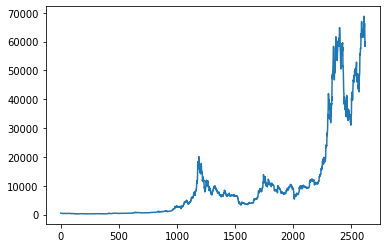

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2618,2618), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-26'),
 Text(0, 0, '2021-04-17')]

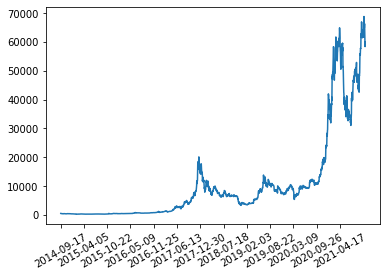

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2618,2618), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [9]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = pd.DataFrame(data, columns = ['High'])
data_high = data_high.to_numpy()


Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(data_high)
data_normalized = scaler.transform(data_high)

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [11]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [12]:
# Choose the number of time steps that the model "looks back"
time_steps = 5

# Produce your dataset based on the number of days the model could look back
X, y = create_dataset(data_normalized, time_steps)

In [13]:
# Check the shape of your dataset; should be (2622-time_steps-1, time_steps) and (2622-time_steps-1,)
print(X.shape, y.shape)

(2612, 5, 1) (2612, 1)


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False)

For this dataset, you need to reshape the partitions for the model to be able to process them.

In [15]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary:

In [16]:
from keras.models import Sequential
from keras.layers import LSTM

# Build your model
model = Sequential()
model.add(LSTM(64))

loss = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam()

metrics = tf.keras.metrics.MeanSquaredError()

model.compile(loss=loss, optimizer=opt, metrics=metrics)

In [17]:
batchsize = 256

epochs =  5

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=.2, shuffle=False)

Epoch 1/5
7/7 [==============================] - 3s 101ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 2/5
7/7 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 4/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0141 - val_mean_squared_error: 0.0141


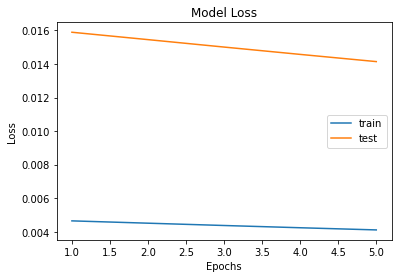

In [18]:
# Plot the Model loss
plt.plot([x+1 for x in range(5)], history.history['loss'])
plt.plot([x+1 for x in range(5)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [19]:
from keras.layers import Dense, Dropout

# Build your model

model = Sequential()
model.add(LSTM(64))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dropout(0.8))
model.add(Dense(1))

loss = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam()

metrics = tf.keras.metrics.MeanSquaredError()

model.compile(loss=loss, optimizer=opt, metrics=metrics)

In [20]:
batchsize = 256
epochs =  5

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=.2, shuffle=False)

Epoch 1/5
7/7 [==============================] - 3s 97ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 2/5
7/7 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/5
7/7 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.3769e-04 - val_mean_squared_error: 5.3769e-04


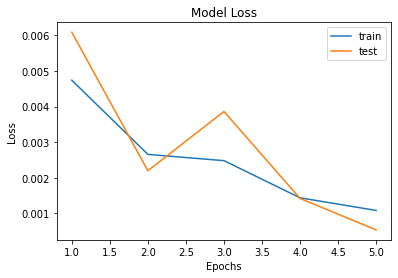

In [21]:
# Plot the Model loss
plt.plot([x+1 for x in range(5)], history.history['loss'])
plt.plot([x+1 for x in range(5)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help? Does your model use dropout or batchnormalization?

**Note:** Your model is trained on normalized data. Inorder to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

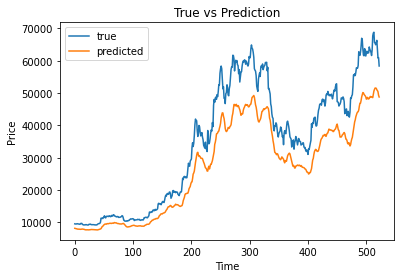

In [22]:
real = scaler.inverse_transform(y_test)
plt.plot(real)
prediction = model.predict(X_test)
predicted = scaler.inverse_transform(prediction)
plt.plot(predicted)
plt.title('True vs Prediction')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['true', 'predicted'])
plt.show()

I don't think there is a clear answer to how look back days affect the accuracy. I ended up going with 5. While getting there I tried some numbers both higher and lower, each having a lower accuracy. Seems like there is a "sweet spot" that gets the best measurements. Yes, adding more layers did help make the MSE smaller. 

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [23]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
import textwrap

# Load data
max_sequence_len = 200 
(X_train, y_train), (_, _) = reuters.load_data(maxlen=max_sequence_len, test_split=0.0)

# Clean and pre-process the data
word_dict = reuters.get_word_index()

word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

vocab_size = len(word_dict.keys())

inverse_word_dict = {value:key for key,value in word_dict.items()}

X_train = pad_sequences(X_train, maxlen=max_sequence_len)

def encode_review(review, word_dict, maxlen):
  encoded_review = []
  for raw_word in review.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_review.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_review).reshape(1,-1), maxlen=maxlen)

def decode_review(encoded_review, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_review:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

# Print sample data
for i in range(5):
  print(decode_review(X_train[i], inverse_word_dict), end='\n\n')
  print('Class Label: ', y_train[i], end='\n\n')

<START> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987
of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs
from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per
share this year should be 2 50 to three dlrs reuter 3

Class Label:  3

<START> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in
factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the
transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3

Class Label:  4

<START> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln
year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1
mln no

### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [25]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model

# Build your model
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 64)(input_layer)
x = LSTM(64)(x) 
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)

reuters_model = Model(input_layer, x)

loss = tf.keras.losses.BinaryCrossentropy()

opt = tf.keras.optimizers.Adam(2e-4)

metrics = ['accuracy']

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 64)           1982912   
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0     

In [26]:
batchsize = 256
epochs =  10

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10
23/23 [==============================] - 4s 74ms/step - loss: 110.2204 - accuracy: 0.0154 - val_loss: 54.9868 - val_accuracy: 0.0092
Epoch 2/10
23/23 [==============================] - 1s 44ms/step - loss: 106.9515 - accuracy: 0.0150 - val_loss: 44.0482 - val_accuracy: 0.0141
Epoch 3/10
23/23 [==============================] - 1s 44ms/step - loss: 105.6807 - accuracy: 0.0157 - val_loss: 37.5187 - val_accuracy: 0.0071
Epoch 4/10
23/23 [==============================] - 1s 43ms/step - loss: 104.2616 - accuracy: 0.0140 - val_loss: 33.2676 - val_accuracy: 0.0056
Epoch 5/10
23/23 [==============================] - 1s 44ms/step - loss: 103.6192 - accuracy: 0.0150 - val_loss: 31.3272 - val_accuracy: 0.0106
Epoch 6/10
23/23 [==============================] - 1s 43ms/step - loss: 102.7471 - accuracy: 0.0145 - val_loss: 30.0098 - val_accuracy: 0.0113
Epoch 7/10
23/23 [==============================] - 1s 43ms/step - loss: 102.3504 - accuracy: 0.0196 - val_loss: 29.1660 - val_accuracy:

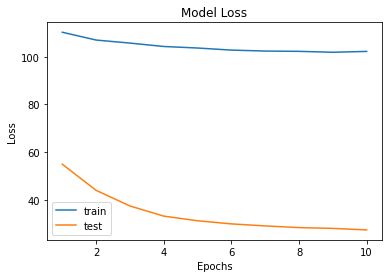

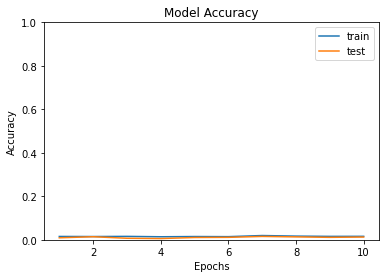

In [27]:
# Plot the Model loss
plt.plot([x+1 for x in range(10)], history.history['loss'])
plt.plot([x+1 for x in range(10)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot([x+1 for x in range(10)], history.history['accuracy'])
plt.plot([x+1 for x in range(10)], history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [29]:
# Build your model
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 128)(input_layer)
x = LSTM(128, activation="relu")(x) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(46, activation='softmax')(x)

model = Model(input_layer, x)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

opt = tf.keras.optimizers.Adam()

metrics = ['accuracy']

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          3965824   
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

In [30]:
batchsize = 256
epochs =  10

# Fit model
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10
23/23 [==============================] - 16s 632ms/step - loss: 3.7916 - accuracy: 0.0929 - val_loss: 3.7001 - val_accuracy: 0.0388
Epoch 2/10
23/23 [==============================] - 14s 622ms/step - loss: nan - accuracy: 0.2986 - val_loss: nan - val_accuracy: 0.0021
Epoch 3/10
23/23 [==============================] - 14s 613ms/step - loss: nan - accuracy: 0.0046 - val_loss: nan - val_accuracy: 0.0021
Epoch 4/10
23/23 [==============================] - 14s 613ms/step - loss: nan - accuracy: 0.0046 - val_loss: nan - val_accuracy: 0.0021
Epoch 5/10
23/23 [==============================] - 14s 624ms/step - loss: nan - accuracy: 0.0046 - val_loss: nan - val_accuracy: 0.0021
Epoch 6/10
23/23 [==============================] - 14s 627ms/step - loss: nan - accuracy: 0.0046 - val_loss: nan - val_accuracy: 0.0021
Epoch 7/10
23/23 [==============================] - 14s 626ms/step - loss: nan - accuracy: 0.0046 - val_loss: nan - val_accuracy: 0.0021
Epoch 8/10
23/23 [=================

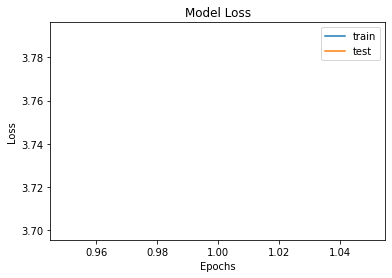

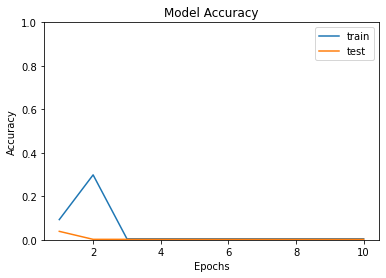

In [31]:
# Plot the Model loss
plt.plot([x+1 for x in range(10)], history.history['loss'])
plt.plot([x+1 for x in range(10)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot([x+1 for x in range(10)], history.history['accuracy'])
plt.plot([x+1 for x in range(10)], history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [33]:
count = 0

for i in y_test:
  #print(y_pred[i], y_test[i])
  if y_test[i] == y_pred[i]:
    count = count + 1

print("Classification Accuracy: ", count/(len(y_test)*100))


NameError: ignored